In [76]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary


In [77]:
class Normalize:
    def __call__(self, sample):
        sample = np.array(sample)
        normalized_sample = (sample - sample.mean()) / sample.std()
        return torch.tensor(normalized_sample, dtype=torch.float32)


transform = transforms.Compose([
    transforms.ToTensor(), 
    Normalize()       
])

In [78]:
full_train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
full_test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)


train_subset_size = 1000
test_subset_size = 200


train_data = torch.utils.data.Subset(full_train_data, range(train_subset_size))
test_data = torch.utils.data.Subset(full_test_data, range(test_subset_size))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 800, 5)
        self.conv4 = nn.Conv2d(800, 800, 1)
        self.conv5 = nn.Conv2d(800, 10, 1)
        self.pool = nn.MaxPool2d((2, 2))


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)) 
        x = x.view(x.size(0), -1)
        return x

model = Net()
summary(model, input_size=(1, 28, 28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3           [-1, 32, 10, 10]           9,248
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Conv2d-5            [-1, 800, 1, 1]         640,800
            Conv2d-6            [-1, 800, 1, 1]         640,800
            Conv2d-7             [-1, 10, 1, 1]           8,010
Total params: 1,299,690
Trainable params: 1,299,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 4.96
Estimated Total Size (MB): 5.18
----------------------------------------------------------------


In [80]:
epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for e in range(epochs):
    running_loss = 0
    correct = 0
    total = 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
       
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
            
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss/len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f"Epoch {e+1}/{epochs}.. "
          f"Train loss: {train_losses[-1]:.3f}.. "
          f"Test loss: {test_losses[-1]:.3f}.. "
          f"Train accuracy: {train_accuracies[-1]:.3f}.. "
          f"Test accuracy: {test_accuracies[-1]:.3f}")

Epoch 1/100.. Train loss: 2.290.. Test loss: 2.252.. Train accuracy: 18.500.. Test accuracy: 43.500
Epoch 2/100.. Train loss: 2.180.. Test loss: 1.986.. Train accuracy: 40.200.. Test accuracy: 56.000
Epoch 3/100.. Train loss: 1.517.. Test loss: 0.787.. Train accuracy: 59.500.. Test accuracy: 66.000
Epoch 4/100.. Train loss: 0.768.. Test loss: 0.657.. Train accuracy: 75.600.. Test accuracy: 80.000
Epoch 5/100.. Train loss: 0.448.. Test loss: 0.351.. Train accuracy: 86.500.. Test accuracy: 87.500
Epoch 6/100.. Train loss: 0.340.. Test loss: 0.292.. Train accuracy: 88.700.. Test accuracy: 90.000
Epoch 7/100.. Train loss: 0.256.. Test loss: 0.240.. Train accuracy: 91.600.. Test accuracy: 95.000
Epoch 8/100.. Train loss: 0.209.. Test loss: 0.109.. Train accuracy: 93.300.. Test accuracy: 96.500
Epoch 9/100.. Train loss: 0.118.. Test loss: 0.099.. Train accuracy: 96.500.. Test accuracy: 96.500
Epoch 10/100.. Train loss: 0.089.. Test loss: 0.142.. Train accuracy: 97.300.. Test accuracy: 96.500

In [81]:
torch.save(model.state_dict(), 'mnist_model.pt')

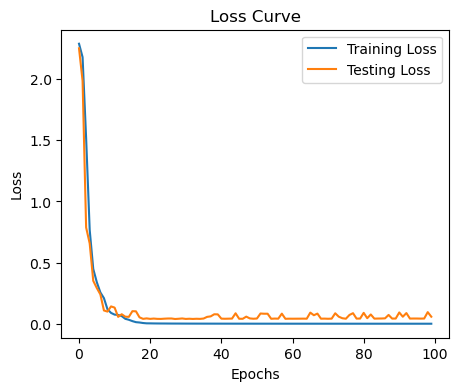

In [82]:
# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

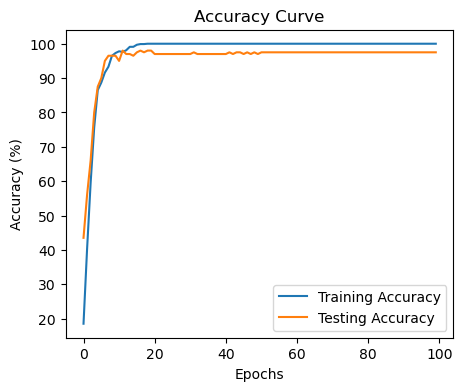

In [83]:
plt.figure(figsize=(5, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()